In [1]:
# 12151411_심경수
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from skimage import transform, io

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# European image preprocessing part
# read european image dataset
data = pd.read_csv('drive/My Drive/fer2013.csv')

# split training, testing data (using 'Usage' category)
train = data[data['Usage'] == 'Training']
test = data[data['Usage'] == 'Testing']
del data

# split data(pixels), class(emotion)
x_train = pd.DataFrame([i.split(' ') for i in train['pixels']]).to_numpy()
y_train = pd.DataFrame(train['emotion']).to_numpy()

x_test = pd.DataFrame([i.split(' ') for i in test['pixels']]).to_numpy()
y_test = pd.DataFrame(test['emotion']).to_numpy()

# reshape for using train, test
x_train = x_train.reshape(x_train.shape[0], 48, 48, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1).astype('float32')

# Normalize before use (Filtering)
x_train /= 255.0
x_test  /= 255.0

# make category (0 ~ 6)
y_train = keras.utils.to_categorical(y_train, 7)
y_test = keras.utils.to_categorical(y_test, 7)

In [0]:
# check it's shape
print("x_train\t: ", x_train.shape)
print("y_train\t: ", y_train.shape)
print("x_test\t: ",  x_test.shape)
print("y_teset\t: ", y_test.shape)

x_train	:  (28709, 48, 48, 1)
y_train	:  (28709, 7)
x_test	:  (7178, 48, 48, 1)
y_teset	:  (7178, 7)


Index	: 36 
Label	: 6 
Emotion	: Neutral


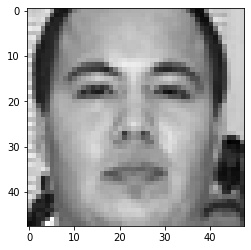

In [26]:
# show 1 image
emotions = { 0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral' }
index = 36

# describe which image include label, it's meaning
print('Index\t:', index,  '\nLabel\t:', np.argmax(y_train[index]), '\nEmotion\t:', emotions[np.argmax(y_train[index])])
plt.imshow(x_train[index].reshape(48, 48), cmap='gray')
plt.show()

In [0]:
# training data augmentaion (reverse right, left)
x_train_reverseLR    = []    # left-right reverse
x_train_reverseUD    = []    # up-down reverse
x_train_reverseUDLR  = []    # left-right, up-down reverse (= 180 rotatation)
x_train_90rotate     = []    # rotate 90
x_train_90reverseLR  = []    # left-right reverse after rotate 90
x_train_90reverseUD  = []    # up-down reverse after rotate 90
x_train_90reverseUDLR= []    # left-right, up-down reverse after rotate 90 (= 270 rotation)

for i in x_train :
    # create rotate, reverse image
    reverseLR = np.flip(i, axis = 1).reshape(-1, 48, 48, 1)
    reverseUD = np.flip(i, axis = 0).reshape(-1, 48, 48, 1)
    reverseUDLR = np.flip(reverseLR, axis = 1)
    rotate_90 = np.rot90(i)
    rotate90_LR  = np.flip(rotate_90, axis = 1)
    rotate90_UD = np.flip(rotate_90, axis = 0)
    rotate90_UDLR = np.flip(rotate90_LR, axis = 0)

    # append images to it's list
    x_train_reverseLR.append(reverseLR)
    x_train_reverseUD.append(reverseUD)
    x_train_reverseUDLR.append(reverseUDLR)
    x_train_90rotate.append(rotate_90)
    x_train_90reverseLR.append(rotate90_LR)
    x_train_90reverseUD.append(rotate90_UD)
    x_train_90reverseUDLR.append(rotate90_UDLR)

# testing data augmentaion (reverse right, left) <== not used in European image test, but used in korean image predict
x_test_reverseLR    = []    # left-right reverse
x_test_reverseUD    = []    # up-down reverse
x_test_reverseUDLR  = []    # left-right, up-down reverse (= 180 rotatation)
x_test_90rotate     = []    # rotate 90
x_test_90reverseLR  = []    # left-right reverse after rotate 90
x_test_90reverseUD  = []    # up-down reverse after rotate 90
x_test_90reverseUDLR= []    # left-right, up-down reverse after rotate 90 (= 270 rotation)

for i in x_test :
    # create rotate, reverse image
    reverseLR = np.flip(i, axis = 1).reshape(-1, 48, 48, 1)
    reverseUD = np.flip(i, axis = 0).reshape(-1, 48, 48, 1)
    reverseUDLR = np.flip(reverseLR, axis = 1).reshape(-1, 48, 48, 1)
    rotate_90 = np.rot90(i)
    rotate90_LR  = np.flip(rotate_90, axis = 1)
    rotate90_UD = np.flip(rotate_90, axis = 0)
    rotate90_UDLR = np.flip(rotate90_LR, axis = 0)

    # append images to it's list
    x_test_reverseLR.append(reverseLR)
    x_test_reverseUD.append(reverseUD)
    x_test_reverseUDLR.append(reverseUDLR)
    x_test_90rotate.append(rotate_90)
    x_test_90reverseLR.append(rotate90_LR)
    x_test_90reverseUD.append(rotate90_UD)
    x_test_90reverseUDLR.append(rotate90_UDLR)

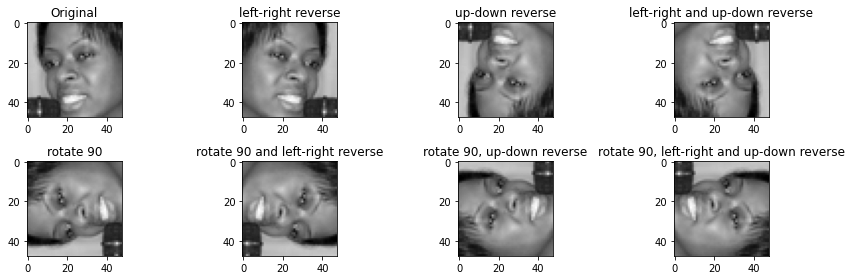

In [0]:
# Check Augmentation
# show original, right-left reverse, up-down reverse, left-right and up-down reverse
index = 93
plt.figure(figsize=(12,4))

plt.subplot(2, 4, 1)
plt.imshow(x_train[index].reshape(48, 48), cmap='gray')
plt.title("Original")

plt.subplot(2, 4, 2)
plt.imshow(x_train_reverseLR[index].reshape(48, 48), cmap='gray')
plt.title("left-right reverse")

plt.subplot(2, 4, 3)
plt.imshow(x_train_reverseUD[index].reshape(48, 48), cmap='gray')
plt.title("up-down reverse")

plt.subplot(2, 4, 4)
plt.imshow(x_train_reverseUDLR[index].reshape(48, 48), cmap='gray')
plt.title("left-right and up-down reverse")

plt.subplot(2, 4, 5)
plt.imshow(x_train_90rotate[index].reshape(48, 48), cmap='gray')
plt.title("rotate 90")

plt.subplot(2, 4, 6)
plt.imshow(x_train_90reverseLR[index].reshape(48, 48), cmap='gray')
plt.title("rotate 90 and left-right reverse")

plt.subplot(2, 4, 7)
plt.imshow(x_train_90reverseUD[index].reshape(48, 48), cmap='gray')
plt.title("rotate 90, up-down reverse")

plt.subplot(2, 4, 8)
plt.imshow(x_train_90reverseUDLR[index].reshape(48, 48), cmap='gray')
plt.title("rotate 90, left-right and up-down reverse")

plt.tight_layout()
plt.show()

In [0]:
# translate same shape as x_train
x_train_reverseLR = np.asarray(x_train_reverseLR, dtype = np.float32).reshape(-1, 48, 48, 1)
x_train_reverseUD = np.asarray(x_train_reverseUD, dtype = np.float32).reshape(-1, 48, 48, 1)
x_train_reverseUDLR = np.asarray(x_train_reverseUDLR, dtype = np.float32).reshape(-1, 48, 48, 1)
x_train_90rotate = np.asarray(x_train_90rotate, dtype = np.float32).reshape(-1, 48, 48, 1)
x_train_90reverseLR = np.asarray(x_train_90reverseLR, dtype = np.float32).reshape(-1, 48, 48, 1)
x_train_90reverseUD = np.asarray(x_train_90reverseUD, dtype = np.float32).reshape(-1, 48, 48, 1)
x_train_90reverseUDLR  = np.asarray(x_train_90reverseUDLR, dtype = np.float32).reshape(-1, 48, 48, 1)

aug_list1 = [ x_train_reverseLR ,x_train_reverseUD, x_train_reverseUDLR, x_train_90rotate,
             x_train_90reverseLR, x_train_90reverseUD, x_train_90reverseUDLR ]
x_train_append = x_train
y_train_append = y_train

# append augmentation picture to x_train list
for i in aug_list1 :
    x_train_append = np.append(x_train_append, i, axis = 0)
    y_train_append = np.append(y_train_append, y_train, axis = 0)

# translate same shape as x_test
x_test_reverseLR = np.asarray(x_test_reverseLR, dtype = np.float32).reshape(-1, 48, 48, 1)
x_test_reverseUD = np.asarray(x_test_reverseUD, dtype = np.float32).reshape(-1, 48, 48, 1)
x_test_reverseUDLR = np.asarray(x_test_reverseUDLR, dtype = np.float32).reshape(-1, 48, 48, 1)
x_test_90rotate = np.asarray(x_test_90rotate, dtype = np.float32).reshape(-1, 48, 48, 1)
x_test_90reverseLR = np.asarray(x_test_90reverseLR, dtype = np.float32).reshape(-1, 48, 48, 1)
x_test_90reverseUD = np.asarray(x_test_90reverseUD, dtype = np.float32).reshape(-1, 48, 48, 1)
x_test_90reverseUDLR  = np.asarray(x_test_90reverseUDLR, dtype = np.float32).reshape(-1, 48, 48, 1)

aug_list2 = [ x_test_reverseLR ,x_test_reverseUD, x_test_reverseUDLR, x_test_90rotate,
             x_test_90reverseLR, x_test_90reverseUD, x_test_90reverseUDLR ]
x_test_append = x_test
y_test_append = y_test

# append augmentation picture to x_test list
for i in aug_list1 :
    x_test_append = np.append(x_test_append, i, axis = 0)
    y_test_append = np.append(y_test_append, y_train, axis = 0)

# remove each augmentation list to save memory
del x_train_reverseLR ,x_train_reverseUD, x_train_reverseUDLR, x_train_90rotate, x_train_90reverseLR, x_train_90reverseUD, x_train_90reverseUDLR
del x_test_reverseLR ,x_test_reverseUD, x_test_reverseUDLR, x_test_90rotate, x_test_90reverseLR, x_test_90reverseUD, x_test_90reverseUDLR 

In [0]:
from keras.models import load_model
# save model
# model.save('drive/My Drive/Emotion_model.h5')

# load model
model = load_model('drive/My Drive/Emotion_model.h5')

In [0]:
def CNN_model() :
    # image shape using in CNN model
    inputShape = (48, 48, 1)

    model = Sequential()
    # Hidden layer - Convolution (with ReLU)
    # MaxPooling2D : choose maximum value in each kernel, and reduce image size
    # BatchNormalization : normalize each result
    # Conv2D : convolution process
    # Dropout : turn off layer's node randomly, to avoid overfitting
    model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = inputShape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = inputShape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Conv2D(48, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    # Flatten layer : Make data 2D to 1D 
    model.add(Flatten())
    
    # Fully connection layer
    model.add(Dense(432, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(7, activation = 'softmax'))
    # ====================================================================================================================
    # model.summary()     # check CNN model

    return model

# see how to study, and evaluate european face and emotion
model = CNN_model()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',  metrics = ['accuracy'])
hist = model.fit(x_train_append, y_train_append, batch_size = 128, epochs = 50, verbose = 1)

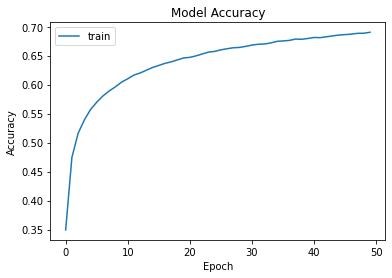

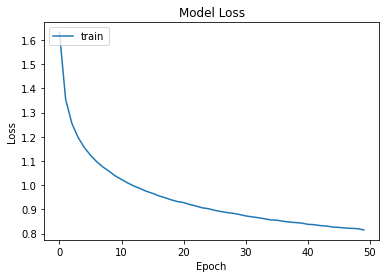

In [0]:
# Accuracy visualization
plt.plot(hist.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss visualization
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [33]:
# Evaluation using "Testing" images
train_evaluation = model.evaluate(x_test, y_test)

print("test Accuracy\t: ", train_evaluation[1])
print("test loss\t: ", train_evaluation[0])

7178/7178 [==============================] - 2s 281us/step
test Accuracy	:  0.6241292953491211
test loss	:  1.0273811022662027


In [0]:
# Korean image preprocessing part
# resize, rgb to gray transfrom korean face images
from PIL import Image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

# korean dataset direction
dataset = pd.read_csv('drive/My Drive/korean_face_dataset_12151411.csv')
actual_dir = 'Images-20200526T065159Z-001/Images/' + dataset['File']

drive_dir = 'drive/My Drive/'         # on colob direction
actual_dir = drive_dir + actual_dir   # actual korean image direction on colab

Dts = dataset['File']           # full korean dataset direction
test_imglist = []               # korean face data list

for index in range(len(Dts)) :
    img_resize = Image.open(actual_dir[index])                # read image
    img_resize = img_resize.resize((48, 48))                  # resize image
    img_resize = np.asarray(img_resize, dtype = np.float32)   # transform image to numpy array
                                                              # (since skimage type is numpy array, so transform numpy array before change color)
    img_resize = color.rgb2gray(img_resize)                   # change color RGB to gray
    img_resize.reshape(-1, 48, 48, 1)                         # reshape array so can use CNN
    test_imglist.append(img_resize)                           # append image to korean face list

# prepare list to use CNN model
test_imglist = np.asarray(test_imglist, dtype = np.float32).reshape(-1, 48, 48, 1)

# Normalize before use (Filtering)
test_imglist /= 255.0
del Dts, dataset

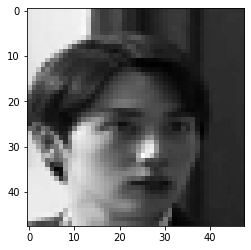

In [0]:
# check transformed korean image
korean_index = 0

plt.imshow(test_imglist[korean_index].reshape(48, 48), cmap='gray')
plt.show()

In [0]:
# Additional : how much increase model accuracy using all european dataset
# add testing European image to train new CNN model
x_train_final = np.append(x_train_append, x_test_append, axis = 0)
del x_train_append, x_test_append
y_train_final = np.append(y_train_append, y_test_append, axis = 0)
del y_train_append, y_test_append

# train model
CNN = CNN_model()
CNN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = CNN.fit(x_train_final, y_train_final, batch_size = 128, epochs = 20, verbose = 1)

In [0]:
# history = CNN.fit(x_train_final, y_train_final, batch_size = 128, epochs = 20, verbose = 1)
from keras.models import load_model
# CNN = load_model('drive/My Drive/Emotion_evaluation_enhanced_model.h5')            # load trained model
# CNN.save('drive/My Drive/Emotion_evaluation_model.h5')                             # save trained model

In [8]:
history = CNN.fit(x_train_final, y_train_final, batch_size = 128, epochs = 30, verbose = 1)

Epoch 1/30
437813/437813 [==============================] - 262s 598us/step - loss: 0.8425 - accuracy: 0.6804
Epoch 2/30
437813/437813 [==============================] - 253s 579us/step - loss: 0.8375 - accuracy: 0.6832
Epoch 3/30
437813/437813 [==============================] - 255s 581us/step - loss: 0.8328 - accuracy: 0.6849
Epoch 4/30
437813/437813 [==============================] - 254s 580us/step - loss: 0.8275 - accuracy: 0.6876
Epoch 5/30
437813/437813 [==============================] - 251s 574us/step - loss: 0.8228 - accuracy: 0.6884
Epoch 6/30
437813/437813 [==============================] - 251s 574us/step - loss: 0.8191 - accuracy: 0.6904
Epoch 7/30
437813/437813 [==============================] - 251s 573us/step - loss: 0.8146 - accuracy: 0.6911
Epoch 8/30
437813/437813 [==============================] - 251s 573us/step - loss: 0.8115 - accuracy: 0.6931
Epoch 9/30
437813/437813 [==============================] - 250s 571us/step - loss: 0.8069 - accuracy: 0.6943
Epoch 10/3

In [0]:
# Make to dataframe for submission file
# predict korean_face emotion using previous model (just using 'Training' data)
korean_predict = model.predict_classes(test_imglist)
korean_predict = pd.DataFrame(korean_predict, columns = ['Emotion'])

# predict korean_face - emotion using new model (using 'Training', 'Testing' data)
additional_predict = CNN.predict_classes(test_imglist)
additional_predict = pd.DataFrame(additional_predict, columns = ['Emotion'])

In [0]:
# save result (korean_predict : trained only 'Training' European data)
submission1 = pd.read_csv('drive/My Drive/korean_face_dataset_12151411.csv')
submission1 = pd.concat((korean_predict.iloc[:, 0], submission1['File']), axis = 1)
submission1.to_csv('drive/My Drive/korean_emotion_korean_predict.csv', index = False)

# save result (editional_predict : trained all European data)
submission2 = pd.read_csv('drive/My Drive/korean_face_dataset_12151411.csv')
submission2 = pd.concat((additional_predict.iloc[:, 0], submission2['File']), axis = 1)
submission2.to_csv('drive/My Drive/korean_emotion_additional_predict.csv', index = False)

In [21]:
# check two model's perdiction (same prediction, difference)
count = 0
diff_list = []

for i in range(601) :
    if predict1[i] == predict2[i] :       # same prediction 
         count += 1
    else :                                # difference => record it's index
        diff_list.append(i)

# same prediction, difference, difference rate
print("Same predict\t: ", count)
print("Same rate\t: ", count / 601 * 100)
print("difference\t: ", 601 - count)
print("difference rate\t: ", (601- count) / 601 * 100)

Same predict	:  343
Same rate	:  57.07154742096506
difference	:  258
difference rate	:  42.92845257903494


Index	: 350 
Korean_predict		:  Happy 
Additional_predict	:  Fear


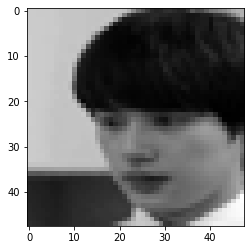

In [28]:
# show what is different
index = diff_list[200]

# describe which image include label, it's meaning
print('Index\t:', index, "\nKorean_predict\t\t: ", emotions[korean_predict['Emotion'][index]], 
                          "\nAdditional_predict\t: ", emotions[additional_predict['Emotion'][index]])
plt.imshow(test_imglist[index].reshape(48, 48), cmap='gray')
plt.show()

In [0]:
# result compare with personal classification
# Be careful : just check about difference of accuracy, but not exactly right it's accuracy
personal_predict_1 = pd.read_csv('drive/My Drive/Face_Emotion_predict/korean_face_dataset_12131569.csv')
personal_predict_2 = pd.read_csv('drive/My Drive/Face_Emotion_predict/korean_face_dataset_12140347.csv')
personal_predict_3 = pd.read_csv('drive/My Drive/Face_Emotion_predict/korean_face_dataset_12151411.csv')
personal_predict_4 = pd.read_csv('drive/My Drive/Face_Emotion_predict/korean_face_dataset_12170151.csv')
personal_predict_5 = pd.read_csv('drive/My Drive/Face_Emotion_predict/korean_face_dataset_12171698.csv')
personal_predict_6 = pd.read_csv('drive/My Drive/Face_Emotion_predict/korean_face_dataset_12181617.csv')

personal_predict1 = personal_predict_1['Emotion'].astype('int64')
personal_predict2 = personal_predict_2['Emotion'].astype('int64')
personal_predict3 = personal_predict_3['Emotion'].astype('int64')
personal_predict4 = personal_predict_4['Emotion'].astype('int64')
personal_predict5 = personal_predict_5['Emotion'].astype('int64')
personal_predict6 = personal_predict_6['Emotion'].astype('int64')

In [30]:
# compare 2 list function
def compare_result(list1, list2) : 
    count = 0
    for i in range(len(list1)) : 
        if list1[i] == list2[i] :
            count += 1
    print("\tAccuracy\t: ", count)
    print('\tAccuracy_rage\t: ',  count / 601 * 100)
    return count / 601

list_predict = [ personal_predict1, personal_predict2, personal_predict3,
                 personal_predict4, personal_predict5, personal_predict6 ]

model_prediction = [ korean_predict['Emotion'], additional_predict['Emotion']]

# compare korean emotion predict with personal classification
for i in range(len(model_prediction)) : 
    print("model_predict ", i+1)
    print("===========================================")
    sum = 0
    for j in range(len(list_predict)) :
        print(j+1, "th personal classification")
        sum += compare_result(model_prediction[i], list_predict[j])
    print("Average accuracy : ", sum / 5 * 100)
    print("===========================================\n")

model_predict  1
1 th personal classification
	Accuracy	:  59
	Accuracy_rage	:  9.816971713810316
2 th personal classification
	Accuracy	:  129
	Accuracy_rage	:  21.46422628951747
3 th personal classification
	Accuracy	:  170
	Accuracy_rage	:  28.286189683860236
4 th personal classification
	Accuracy	:  135
	Accuracy_rage	:  22.462562396006653
5 th personal classification
	Accuracy	:  144
	Accuracy_rage	:  23.960066555740433
6 th personal classification
	Accuracy	:  112
	Accuracy_rage	:  18.63560732113145
Average accuracy :  24.92512479201331

model_predict  2
1 th personal classification
	Accuracy	:  46
	Accuracy_rage	:  7.653910149750416
2 th personal classification
	Accuracy	:  110
	Accuracy_rage	:  18.302828618968388
3 th personal classification
	Accuracy	:  156
	Accuracy_rage	:  25.9567387687188
4 th personal classification
	Accuracy	:  111
	Accuracy_rage	:  18.469217970049918
5 th personal classification
	Accuracy	:  128
	Accuracy_rage	:  21.29783693843594
6 th personal classific

In [31]:
# compare each personal prediction
for i in range(len(list_predict)) : 
    print("personal_predict ", i+1)
    print("===========================================")
    sum = 0
    for j in range(len(list_predict)) :
        if i != j : 
            print("With ", j+1, "th predict")
            sum += compare_result(list_predict[i], list_predict[j])
    print("\nAverage accuracy : ", sum / 5 * 100)
    print("===========================================\n")

personal_predict  1
With  2 th predict
	Accuracy	:  90
	Accuracy_rage	:  14.975041597337771
With  3 th predict
	Accuracy	:  74
	Accuracy_rage	:  12.312811980033278
With  4 th predict
	Accuracy	:  66
	Accuracy_rage	:  10.98169717138103
With  5 th predict
	Accuracy	:  58
	Accuracy_rage	:  9.650582362728786
With  6 th predict
	Accuracy	:  84
	Accuracy_rage	:  13.976705490848584

Average accuracy :  12.37936772046589

personal_predict  2
With  1 th predict
	Accuracy	:  90
	Accuracy_rage	:  14.975041597337771
With  3 th predict
	Accuracy	:  158
	Accuracy_rage	:  26.28951747088186
With  4 th predict
	Accuracy	:  134
	Accuracy_rage	:  22.296173044925123
With  5 th predict
	Accuracy	:  156
	Accuracy_rage	:  25.9567387687188
With  6 th predict
	Accuracy	:  117
	Accuracy_rage	:  19.467554076539102

Average accuracy :  21.79700499168053

personal_predict  3
With  1 th predict
	Accuracy	:  74
	Accuracy_rage	:  12.312811980033278
With  2 th predict
	Accuracy	:  158
	Accuracy_rage	:  26.289517470881